# 11_1 In class example, Classification with questions
We will load the breast cancer dataset and figure out what is the most important predictor(s) for breast cancer. And then see what happens to the prognosis when these predictors are permuted.

<mark>Note:  Any data gleaned from this sort of thing is only as good as your model.  So if your model is very bad at making predictions then it's notions about what are the most important predictors are also very bad!

See <a href="https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py">this</a> page for a different take on removing correlated columns

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
#want to filter the seaborn warnings
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.filterwarnings("ignore", category=FutureWarning)
# import os
# import sys
# PROJECT_ROOT = os.path.abspath(os.path.join(
#                   os.getcwd(),
#                   os.pardir)
# )

# #only add it once
# if (PROJECT_ROOT not in sys.path):
#     sys.path.append(PROJECT_ROOT)
to_drop=[]  #modified later

# Load Data

In [91]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
# X, y = data.data, data.target
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [49]:
#want a description of the dataset?
# for line in data.DESCR.split("\n"):
#     print(line)

In [50]:
data['feature_names']

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [92]:
#want to see it all in a dataframe?
df = pd.DataFrame(data= np.c_[data['data']],
                     columns= data['feature_names'])
y=pd.Series(data['target'])

In [93]:
#there are no nulls
%time
df.isnull().sum().sum()

CPU times: user 10 µs, sys: 0 ns, total: 10 µs
Wall time: 18.4 µs


0

In [94]:
#is it balanced?
print(f' %{y.sum()/y.shape[0]*100} of dataset is non-cancerous')

 %62.741652021089635 of dataset is non-cancerous


## Any correlations?  If so dump em
Correlations interfere with calculating importance.  For instance, if you have 2 highly correlated columns; A and B.  If you scramble A then B still has As information.  This will result in a lower importance value for both features, where they might actually be important.

In [95]:
# import utils as ut
# df=ut.drop_correlated_columns(df)

In [96]:
# fig, ax = plt.subplots(figsize=(15, 15))
corr = df.corr(method='spearman').abs()

# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

#BTW how do you choose a threshold here? If you vary this from .98 to .65 you will see a decrease and then increase in model accuracy.
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
print(f'Dropping {to_drop}')
df=df.drop(columns=to_drop)
to_drop=[]

Dropping ['mean perimeter', 'mean area', 'mean concave points', 'perimeter error', 'area error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst compactness', 'worst concavity', 'worst concave points']


In [21]:
#make the heatmap fit on the screen
# plt.figure(figsize=(16, 5))

# # generate the correlation matrix (abs converts to absolute value, this way we only look for 1 color range)
# corr = df.corr(method='spearman').abs()

# # Generate mask for the upper triangle (see https://seaborn.pydata.org/examples/many_pairwise_correlations.html)
# # the matrix is symmetric, the diagonal (all 1's) and upper triangle are visual noise, use this to mask both out
# mask = np.tril(np.ones_like(corr, dtype=bool), k=-1)    #k=-1 means get rid of the diagonal

# corr = corr.where(cond=mask)

# sns.heatmap(corr, annot=True);

# Get train test split

In [97]:
#get train test split
X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=42)

# Any additional columns to Drop?

In [98]:
X_train.drop(columns=to_drop,inplace=True)
X_test.drop(columns=to_drop,inplace=True)

# Train a model

In [99]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
print("Accuracy on test data: {:.2f}".format(clf.score(X_test, y_test)))

Accuracy on test data: 0.98


# Check metrics

In [100]:
from sklearn.metrics import classification_report
def show_metrics(clf,X,Y):
    res = clf.predict(X)
    prec_rec = classification_report(Y, res)
    print (prec_rec)
show_metrics(clf,X_test,y_test)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        54
           1       0.98      0.99      0.98        89

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143



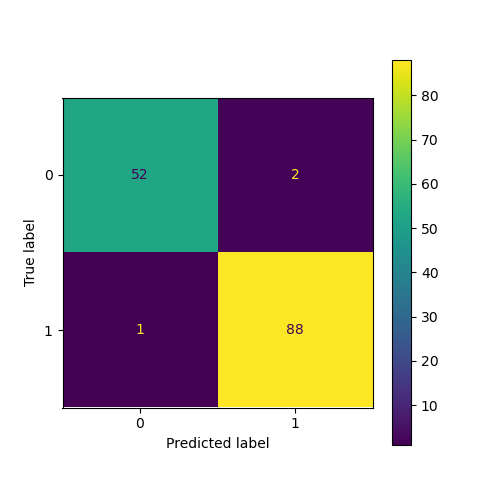

In [101]:
# Thats a little lean in terms of content
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, clf.predict(X_test), labels=[0,1])
fig, ax = plt.subplots(figsize=(5,5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1]).plot(ax=ax)

# Permutation importance

In [102]:
from sklearn.inspection import permutation_importance

In [103]:
%%time
result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42,  scoring='accuracy')
forest_importances = pd.Series(result.importances_mean, index=X_test.columns)

CPU times: user 1.37 s, sys: 0 ns, total: 1.37 s
Wall time: 1.37 s


In [104]:
#do we want to drop all the columns that permutation importance say are unimportant?
to_drop=[forest_importances.index[i] for i,val in enumerate(forest_importances) if val <=0]
to_drop

['mean smoothness', 'texture error', 'concavity error']

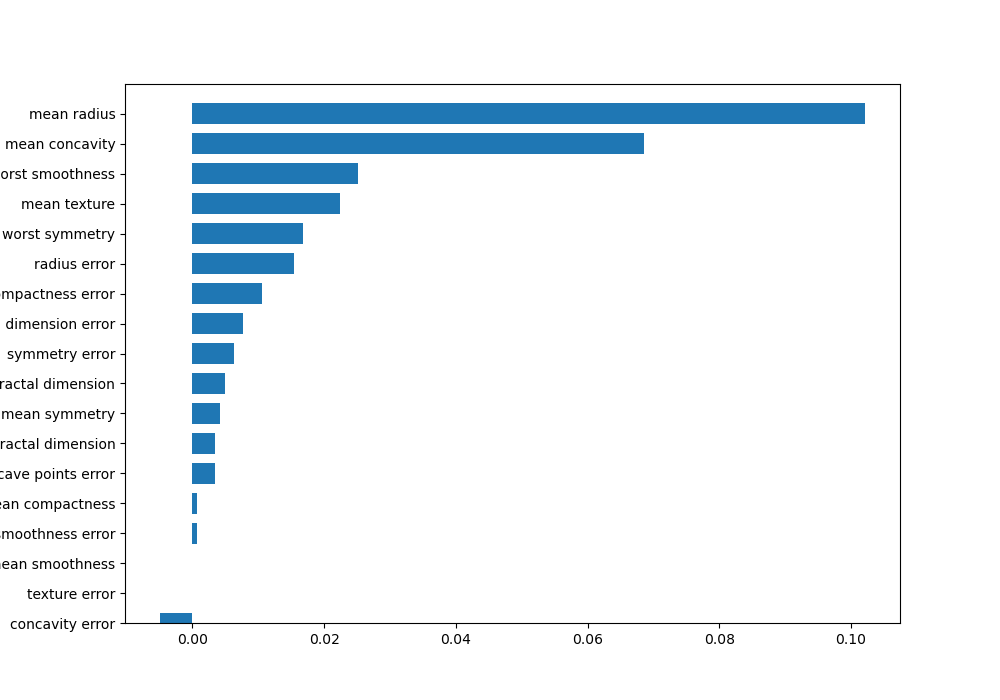

In [105]:
#plot em
forest_importances = forest_importances.sort_values(ascending=True)
tree_indices = forest_importances.index

fig, ax = plt.subplots(figsize=(10,7))
_=ax.barh(tree_indices, forest_importances, height=0.7)
_=ax.set_yticks(tree_indices)
_=ax.set_yticklabels(tree_indices)
_=ax.set_ylim((0, len(tree_indices)))


In [61]:
# forest_importances
# forest_importances.index
# forest_importances
# # forest_importances['mean radius']

# ICE It looks like 'mean radius' matters quite a bit.  What happens if it's permuted?

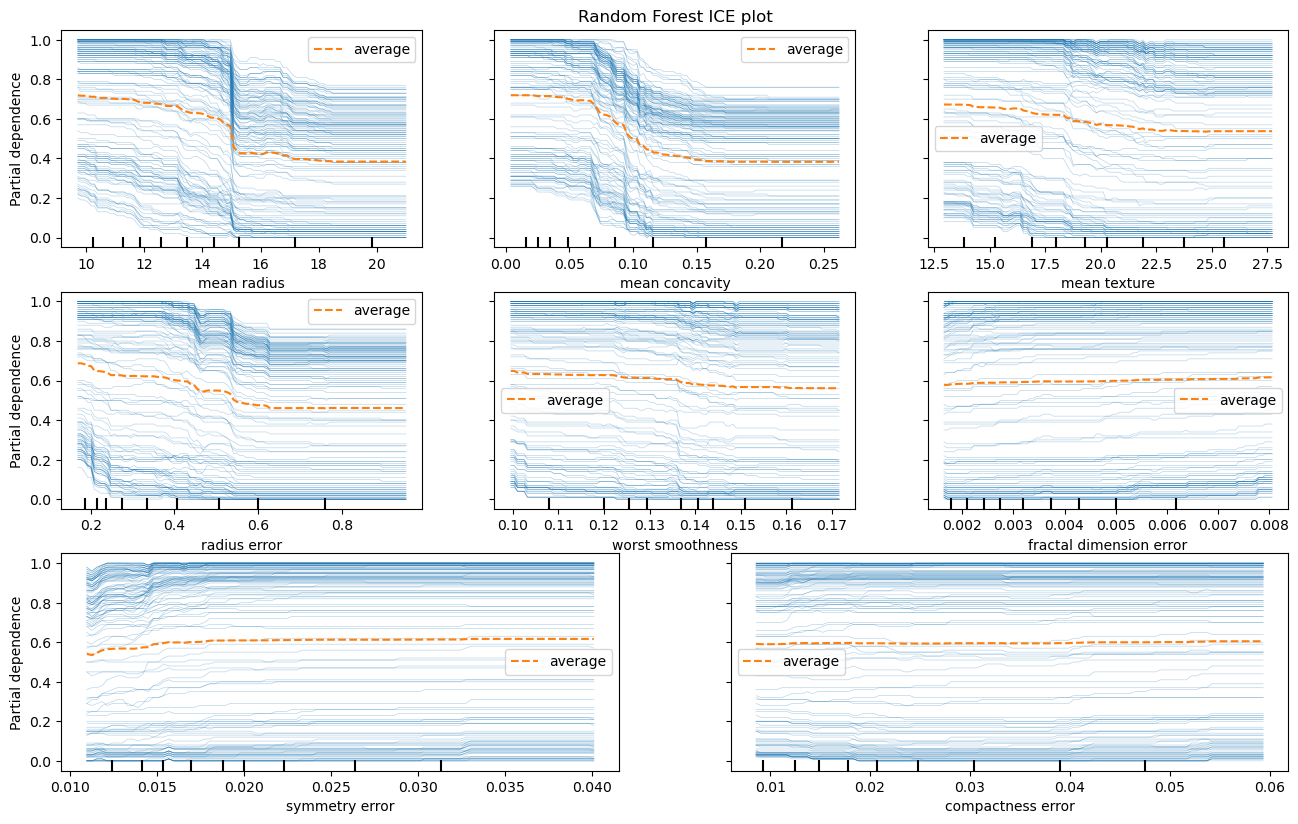

In [44]:
fig, ax = plt.subplots(3,1,figsize=(13, 8))
fig.tight_layout()
# ax[0]
ax[0].set_title("Random Forest ICE plot")
from sklearn.inspection import PartialDependenceDisplay

# PartialDependenceDisplay.from_estimator(clf, X_train, features=['mean radius', 'mean concavity','mean texture'],kind='both', ax=ax)
PartialDependenceDisplay.from_estimator(clf, X_test, features=['mean radius', 'mean concavity','mean texture'],kind='both', ax=ax[0])
PartialDependenceDisplay.from_estimator(clf, X_test, features=['radius error','worst smoothness', 'fractal dimension error'],kind='both', ax=ax[1])
PartialDependenceDisplay.from_estimator(clf, X_test, features=['symmetry error', 'compactness error'],kind='both', ax=ax[2])

# And the PDP

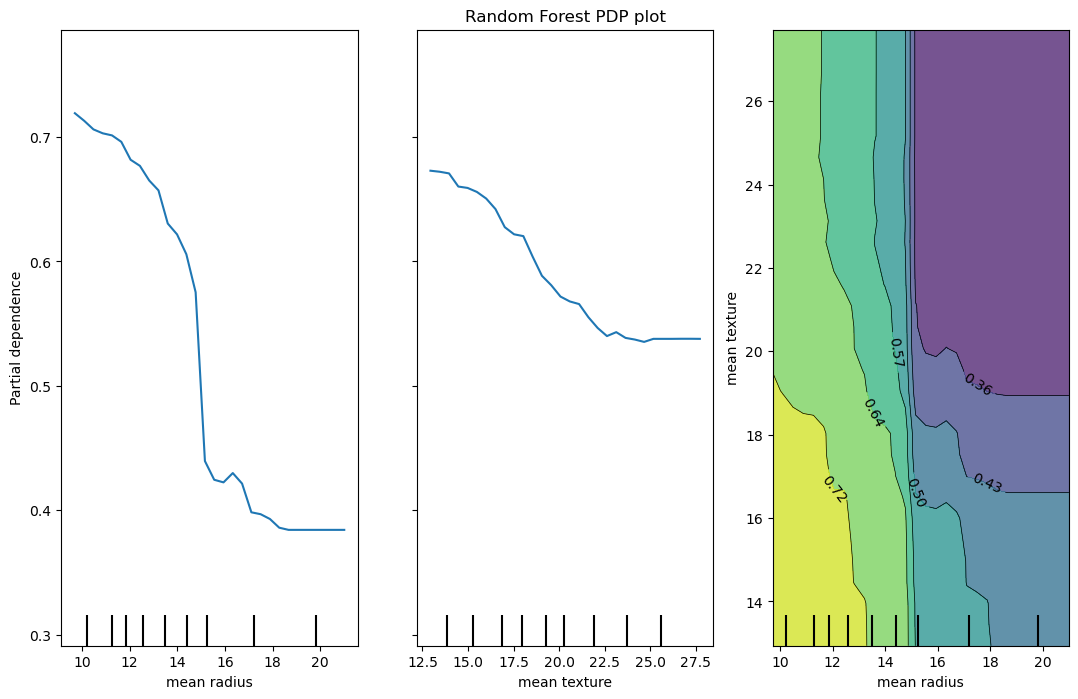

In [45]:
from sklearn.inspection import PartialDependenceDisplay
fig, ax = plt.subplots(figsize=(13, 8))
ax.set_title("Random Forest PDP plot")
my_plots = PartialDependenceDisplay.from_estimator(clf, 
                                   features=[0,1,(0,1)], 
                                   X=X_test, 
                                   feature_names=['mean radius','mean texture'], 
                                   grid_resolution=30, ax=ax)

# Lets 3d plot these features

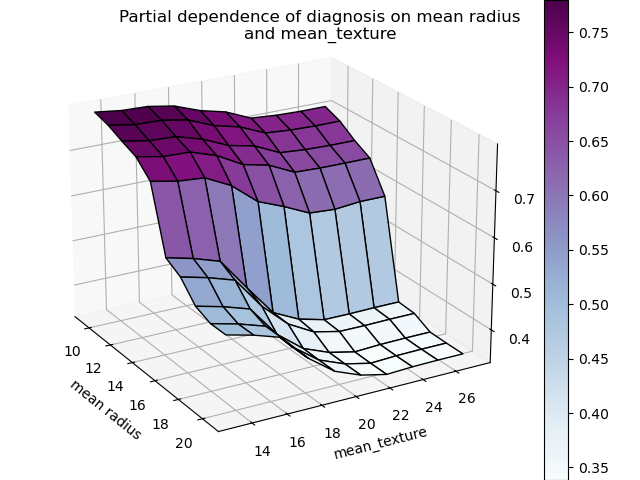

In [46]:
from sklearn.inspection import partial_dependence,PartialDependenceDisplay
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
%matplotlib ipympl
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()

# features = ("AveOccup", "HouseAge")
pdp = partial_dependence(
    clf, X_train, features=[0,1], kind="average", grid_resolution=10
)
XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1])
Z = pdp.average[0].T
ax = Axes3D(fig)
fig.add_axes(ax)

surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor="k")
ax.set_xlabel('mean radius')
ax.set_ylabel('mean_texture')
ax.set_zlabel("Partial dependence")
# pretty init view
ax.view_init(elev=22, azim=-30)
plt.colorbar(surf)
plt.suptitle(
    "Partial dependence of diagnosis on mean radius\n"
    "and mean_texture"
)
plt.subplots_adjust(top=0.9)
plt.show()